<a href="https://colab.research.google.com/github/Massizelle/TP-analyse-d-images/blob/main/TP_Texture_Matching.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TP - Analyse d'images : Texture & Features Matching


## Import des bibliothèques

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import zipfile
import os
import io

from skimage import color, filters, measure
from skimage.feature import local_binary_pattern
from scipy.stats import entropy as scipy_entropy
import cv2
from PIL import Image

## Chargement des images depuis le ZIP

In [ ]:
ZIP_PATH = "/content/7-images.zip"

EXTRACT_FOLDER = "images_zebra"

# Extraction du ZIP
with zipfile.ZipFile(ZIP_PATH, 'r') as z:
    z.extractall(EXTRACT_FOLDER)
    print("Fichiers extraits :")
    for f in z.namelist():
        print(" -", f)

# Liste des images zèbre trouvées
all_files = []
for root, dirs, files in os.walk(EXTRACT_FOLDER):
    for f in sorted(files):
        if f.lower().endswith(('.tif')):
            all_files.append(os.path.join(root, f))

print(f"\n{len(all_files)} image(s) trouvée(s) :")
for f in all_files:
    print(" -", f)

Fichiers extraits :
 - 7-images/
 - 7-images/bretelle.jpg
 - 7-images/zebra_2.tif
 - 7-images/zebra_3.tif
 - 7-images/coins.png
 - 7-images/football.jpg
 - 7-images/corridor.png
 - 7-images/zebra_1.tif
 - 7-images/zebra_4.tif
 - 7-images/zebra_5.tif
 - 7-images/zebra_6.tif

6 image(s) trouvée(s) :
 - images_zebra/7-images/zebra_1.tif
 - images_zebra/7-images/zebra_2.tif
 - images_zebra/7-images/zebra_3.tif
 - images_zebra/7-images/zebra_4.tif
 - images_zebra/7-images/zebra_5.tif
 - images_zebra/7-images/zebra_6.tif


Image chargée : images_zebra/7-images/zebra_5.tif


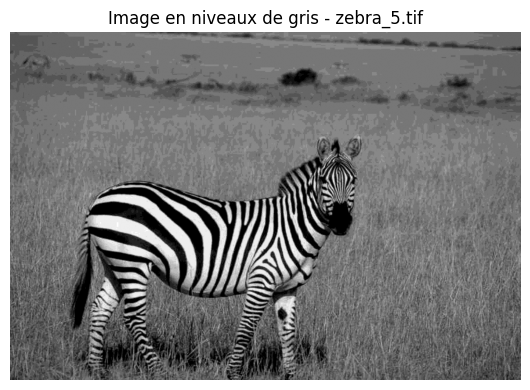

Taille : (600, 881)


In [ ]:
img_path = all_files[4]
print(f"Image chargée : {img_path}")

img_gray  =  np.array(Image.open(img_path))                    # float [0,1]
img_uint8 = (img_gray * 255).astype(np.uint8)             # uint8 [0,255]

plt.figure(figsize=(6, 4))
plt.imshow(img_gray, cmap='gray')
plt.title(f"Image en niveaux de gris - {os.path.basename(img_path)}")
plt.axis('off')
plt.tight_layout()
plt.show()
print(f"Taille : {img_gray.shape}")

# Exercice 1 – Texture
## Partie 1 – fonction GLCM

In [ ]:
import numpy as np

def my_glcm(window, num_levels=32):

    # Initialisation de la GLCM avec des zéros
    glcm = np.zeros((num_levels, num_levels), dtype=float)
    rows, cols = window.shape  # dimensions de la fenêtre

    # Parcours de chaque pixel (sauf la dernière colonne)
    for i in range(rows):
        for j in range(cols - 1):
            v1 = int(window[i, j])      # niveau de gris du pixel courant
            v2 = int(window[i, j + 1])  # niveau de gris du pixel voisin à droite
            glcm[v1, v2] += 1           # incrément de la co-occurrence
            glcm[v2, v1] += 1           # symétrie de la GLCM

    # Normalisation pour que la somme des éléments soit 1
    total = glcm.sum()
    if total > 0:
        glcm /= total
    return glcm


def glcm_variance(glcm):
    n = glcm.shape[0]
    idx = np.arange(n)  # indices correspondant aux niveaux de gris
    mean = np.sum(idx * glcm.sum(axis=1))  # moyenne pondérée des niveaux de gris
    # variance = somme des carrés des écarts à la moyenne, pondérée par les occurrences
    return np.sum((idx - mean) ** 2 * glcm.sum(axis=1))


def glcm_contrast(glcm):
    n = glcm.shape[0]
    i_idx, j_idx = np.meshgrid(np.arange(n), np.arange(n), indexing='ij')  # indices pour chaque élément
    # contraste = somme des carrés des différences pondérées par les co-occurrences
    return np.sum((i_idx - j_idx) ** 2 * glcm)


def glcm_entropy(glcm):
    flat = glcm[glcm > 0]  # éviter log(0)
    return -np.sum(flat * np.log2(flat))


In [ ]:
def sliding_window_features(image, window_size=32, num_levels=32, step=16):
    """
    Calcule les cartes de variance, contraste et entropie sur une image
    en utilisant une fenêtre glissante et la GLCM.
    """
    h, w = image.shape  # dimensions de l'image

    # Réduction des niveaux de gris pour correspondre au nombre de niveaux GLCM
    img_reduced = (image / 255.0 * (num_levels - 1)).astype(int)
    img_reduced = np.clip(img_reduced, 0, num_levels - 1)  # s'assurer que les valeurs restent dans [0, num_levels-1]

    # Initialisation des cartes de caractéristiques
    var_map      = np.zeros((h, w))
    contrast_map = np.zeros((h, w))
    entropy_map  = np.zeros((h, w))

    # Parcours de l'image avec une fenêtre glissante
    for i in range(0, h - window_size, step):
        for j in range(0, w - window_size, step):
            # Extraire la fenêtre courante
            win = img_reduced[i:i+window_size, j:j+window_size]

            # Calculer la GLCM pour cette fenêtre
            glcm = my_glcm(win, num_levels=num_levels)

            # Déterminer le centre de la fenêtre pour placer la valeur calculée
            ci = i + window_size // 2
            cj = j + window_size // 2

            # Calcul des caractéristiques GLCM et stockage dans les cartes
            var_map[ci, cj]      = glcm_variance(glcm)
            contrast_map[ci, cj] = glcm_contrast(glcm)
            entropy_map[ci, cj]  = glcm_entropy(glcm)

    return var_map, contrast_map, entropy_map


var_map, contrast_map, entropy_map = sliding_window_features(
    img_uint8, window_size=32, num_levels=32, step=16
)

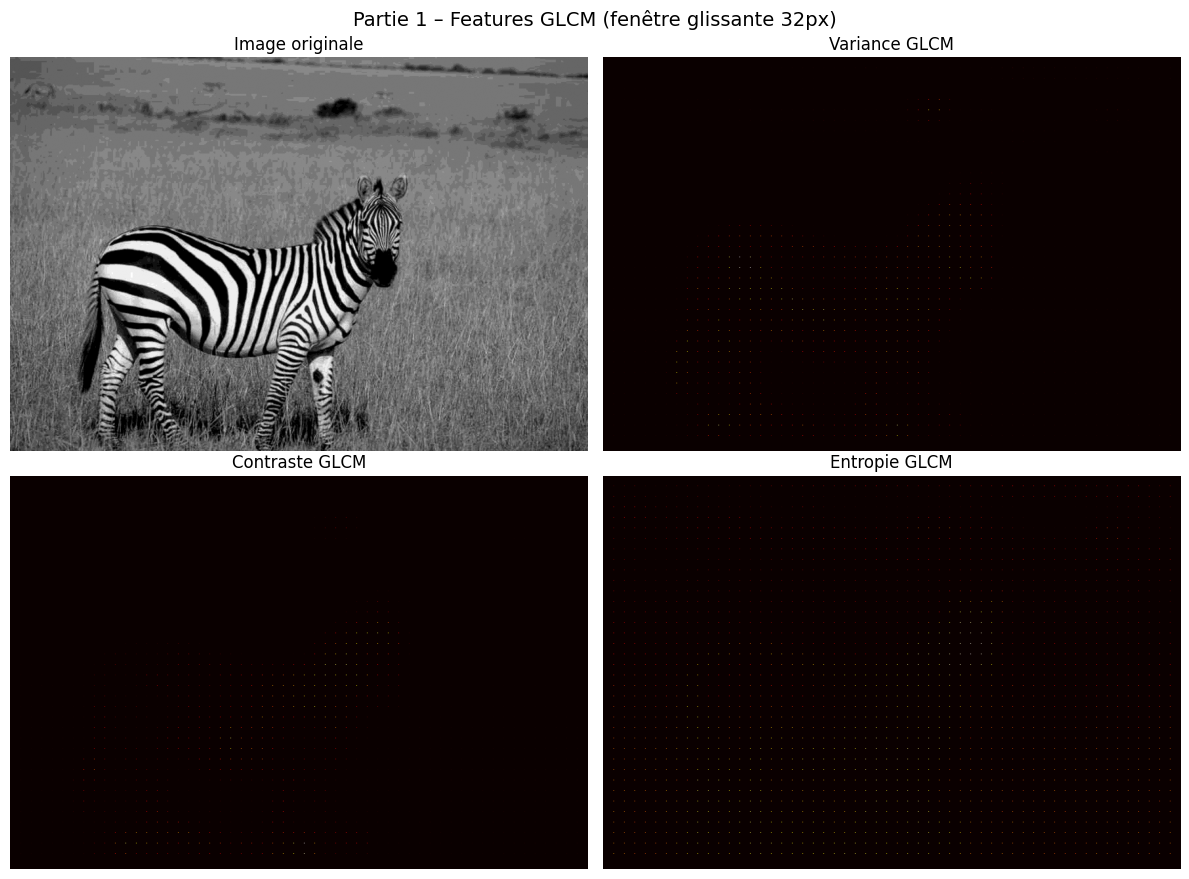

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(12, 9))
fig.suptitle("Partie 1 – Features GLCM (fenêtre glissante 32px)", fontsize=14)

axes[0, 0].imshow(img_gray, cmap='gray')
axes[0, 0].set_title("Image originale")
axes[0, 0].axis('off')

axes[0, 1].imshow(var_map, cmap='hot')
axes[0, 1].set_title("Variance GLCM")
axes[0, 1].axis('off')

axes[1, 0].imshow(contrast_map, cmap='hot')
axes[1, 0].set_title("Contraste GLCM")
axes[1, 0].axis('off')

axes[1, 1].imshow(entropy_map, cmap='hot')
axes[1, 1].set_title("Entropie GLCM")
axes[1, 1].axis('off')

plt.tight_layout()
plt.show()

## Partie 2 – Seuillage pour masquer les zèbres

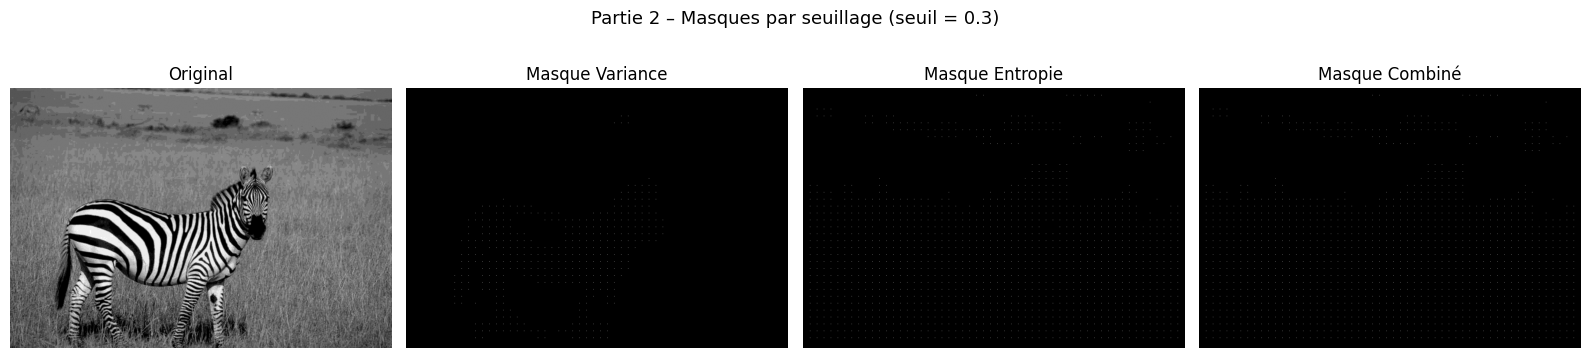

In [ ]:
def normalize(arr):
    """Normalise un tableau entre 0 et 1."""
    mn, mx = arr.min(), arr.max()
    if mx == mn:
        return arr
    return (arr - mn) / (mx - mn)


# Normalisation
var_norm      = normalize(var_map)
contrast_norm = normalize(contrast_map)
entropy_norm  = normalize(entropy_map)

SEUIL = 0.3

mask_var      = var_norm      > SEUIL
mask_contrast = contrast_norm > SEUIL
mask_entropy  = entropy_norm  > SEUIL
mask_combined = mask_var | mask_contrast | mask_entropy

fig, axes = plt.subplots(1, 4, figsize=(16, 4))
fig.suptitle(f"Partie 2 – Masques par seuillage (seuil = {SEUIL})", fontsize=13)

axes[0].imshow(img_gray, cmap='gray')    ; axes[0].set_title("Original")       ; axes[0].axis('off')
axes[1].imshow(mask_var, cmap='gray')    ; axes[1].set_title("Masque Variance") ; axes[1].axis('off')
axes[2].imshow(mask_entropy, cmap='gray'); axes[2].set_title("Masque Entropie") ; axes[2].axis('off')
axes[3].imshow(mask_combined, cmap='gray'); axes[3].set_title("Masque Combiné") ; axes[3].axis('off')

plt.tight_layout()
plt.show()

## Partie 3 – Comparaison avec les mesures du 1er ordre

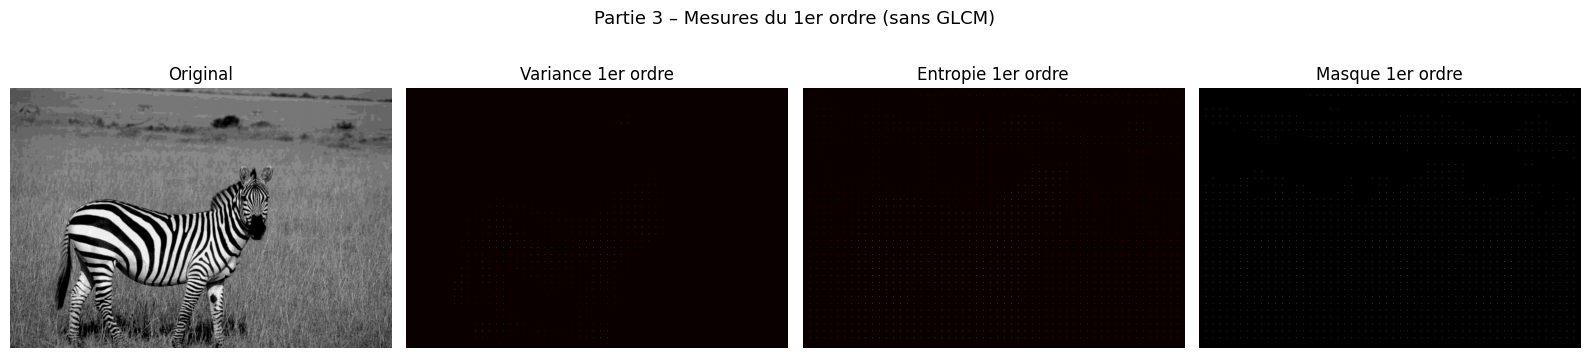


 Comparaison GLCM vs 1er ordre :
  La GLCM capture les relations ENTRE pixels voisins => plus précise pour la texture.
  Le 1er ordre regarde juste la distribution des valeurs => plus rapide mais moins fin.


In [ ]:
def first_order_features(image, window_size=32, step=16):
    """
    Variance et entropie du 1er ordre avec fenêtre glissante.
    (calcul sur l'histogramme local, sans GLCM)
    """
    h, w = image.shape
    var_map1  = np.zeros((h, w))
    entr_map1 = np.zeros((h, w))

    for i in range(0, h - window_size, step):
        for j in range(0, w - window_size, step):
            win = image[i:i+window_size, j:j+window_size].flatten().astype(float)

            v = np.var(win)

            hist, _ = np.histogram(win, bins=32, range=(0, 255), density=True)
            hist = hist[hist > 0]
            e = scipy_entropy(hist, base=2)

            ci = i + window_size // 2
            cj = j + window_size // 2
            var_map1[ci, cj]  = v
            entr_map1[ci, cj] = e

    return var_map1, entr_map1


#Calcul 1er ordre
var_map1, entr_map1 = first_order_features(img_uint8, window_size=32, step=16)


mask_var1  = normalize(var_map1)  > 0.3
mask_entr1 = normalize(entr_map1) > 0.3

fig, axes = plt.subplots(1, 4, figsize=(16, 4))
fig.suptitle("Partie 3 – Mesures du 1er ordre (sans GLCM)", fontsize=13)

axes[0].imshow(img_gray, cmap='gray')    ; axes[0].set_title("Original")                  ; axes[0].axis('off')
axes[1].imshow(var_map1, cmap='hot')     ; axes[1].set_title("Variance 1er ordre")         ; axes[1].axis('off')
axes[2].imshow(entr_map1, cmap='hot')    ; axes[2].set_title("Entropie 1er ordre")          ; axes[2].axis('off')
axes[3].imshow(mask_var1 | mask_entr1, cmap='gray'); axes[3].set_title("Masque 1er ordre") ; axes[3].axis('off')

plt.tight_layout()
plt.show()

print("\n Comparaison GLCM vs 1er ordre :")
print("  La GLCM capture les relations ENTRE pixels voisins => plus précise pour la texture.")
print("  Le 1er ordre regarde juste la distribution des valeurs => plus rapide mais moins fin.")

## Partie 4 – LBP (Local Binary Patterns)

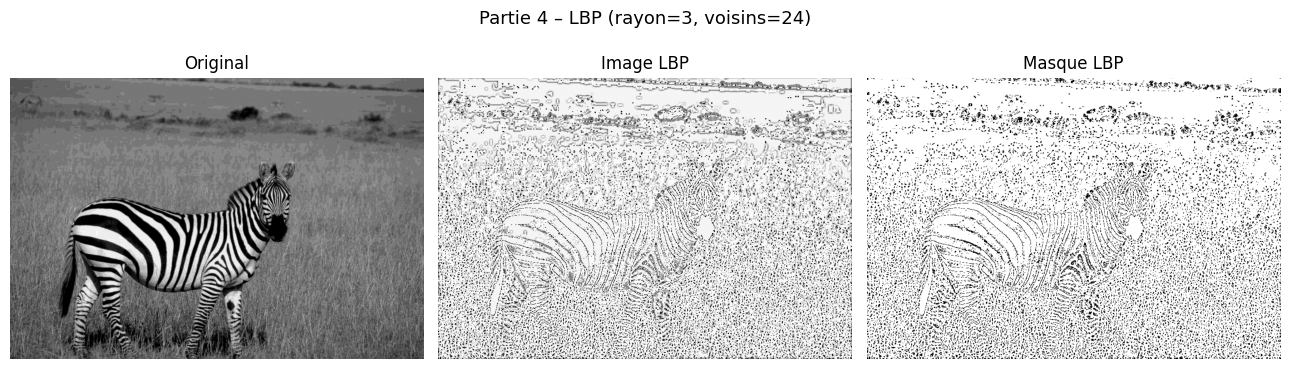

 Le LBP encode le motif local autour de chaque pixel.
 C'est très efficace pour capturer les textures répétitives comme les rayures du zèbre 


In [ ]:
# Paramètres LBP
RADIUS   = 3           # rayon autour du pixel central
N_POINTS = 8 * RADIUS  # nombre de voisins

lbp_image = local_binary_pattern(img_uint8, P=N_POINTS, R=RADIUS, method='uniform')

# Ajuste le seuil LBP
SEUIL_LBP = 0.5
mask_lbp  = normalize(lbp_image) > SEUIL_LBP

fig, axes = plt.subplots(1, 3, figsize=(13, 4))
fig.suptitle(f"Partie 4 – LBP (rayon={RADIUS}, voisins={N_POINTS})", fontsize=13)

axes[0].imshow(img_gray, cmap='gray')  ; axes[0].set_title("Original")   ; axes[0].axis('off')
axes[1].imshow(lbp_image, cmap='gray') ; axes[1].set_title("Image LBP")  ; axes[1].axis('off')
axes[2].imshow(mask_lbp, cmap='gray')  ; axes[2].set_title("Masque LBP") ; axes[2].axis('off')

plt.tight_layout()
plt.show()

print(" Le LBP encode le motif local autour de chaque pixel.")
print(" C'est très efficace pour capturer les textures répétitives comme les rayures du zèbre ")

---
# Exercice 2 –  matcher des points entre deux images de zèbres

Image 1 : zebra_1.tif → shape: (400, 640)
Image 2 : zebra_2.tif → shape: (563, 881)

Points clés image 1 : 500
Points clés image 2 : 500
Correspondances trouvées : 148


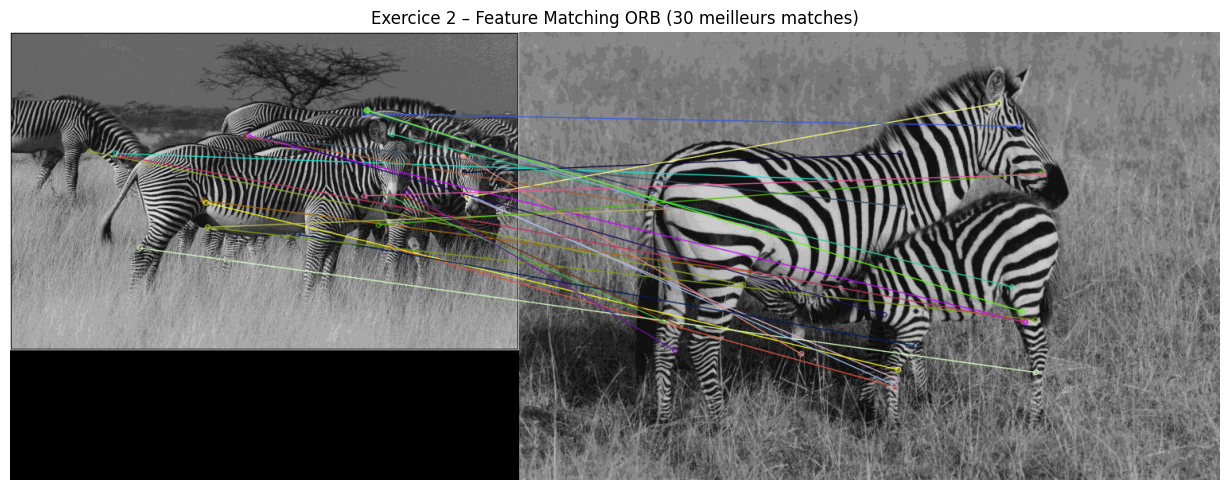

In [ ]:
import numpy as np
from PIL import Image

def load_gray_cv(path):
    pil_img = Image.open(path).convert('L')
    return np.array(pil_img)

# Chargement de deux images
if len(all_files) >= 2:
    img1_cv = load_gray_cv(all_files[0])
    img2_cv = load_gray_cv(all_files[1])
    print(f"Image 1 : {os.path.basename(all_files[0])} → shape: {img1_cv.shape}")
    print(f"Image 2 : {os.path.basename(all_files[1])} → shape: {img2_cv.shape}")
else:
    img1_cv = img_uint8.copy()
    img2_cv = np.roll(img_uint8, 30, axis=1)
    print("Une seule image disponible → on utilise une version décalée.")

# Détection ORB
orb = cv2.ORB_create(nfeatures=500)
kp1, des1 = orb.detectAndCompute(img1_cv, None)
kp2, des2 = orb.detectAndCompute(img2_cv, None)

print(f"\nPoints clés image 1 : {len(kp1)}")
print(f"Points clés image 2 : {len(kp2)}")

# Matching Brute Force
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

if des1 is not None and des2 is not None and len(des1) > 0 and len(des2) > 0:
    matches = bf.match(des1, des2)
    matches = sorted(matches, key=lambda x: x.distance)
    print(f"Correspondances trouvées : {len(matches)}")

    img_matches = cv2.drawMatches(
        img1_cv, kp1, img2_cv, kp2,
        matches[:30], None,
        flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
    )

    plt.figure(figsize=(16, 5))
    plt.imshow(img_matches, cmap='gray')
    plt.title("Exercice 2 – Feature Matching ORB (30 meilleurs matches)")
    plt.axis('off')
    plt.tight_layout()
    plt.show()
else:
    print("Descripteurs vides")
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    axes[0].imshow(img1_cv, cmap='gray')
    axes[0].set_title(f"Image 1 : {os.path.basename(all_files[0])}")
    axes[0].axis('off')
    axes[1].imshow(img2_cv, cmap='gray')
    axes[1].set_title(f"Image 2 : {os.path.basename(all_files[1])}")
    axes[1].axis('off')
    plt.tight_layout()
    plt.show()

# Exercice 3 – Moments et propriétés des régions

## Partie 1 – Image binaire et labellisation

Seuil Otsu : 68.000
Nombre de régions détectées : 251


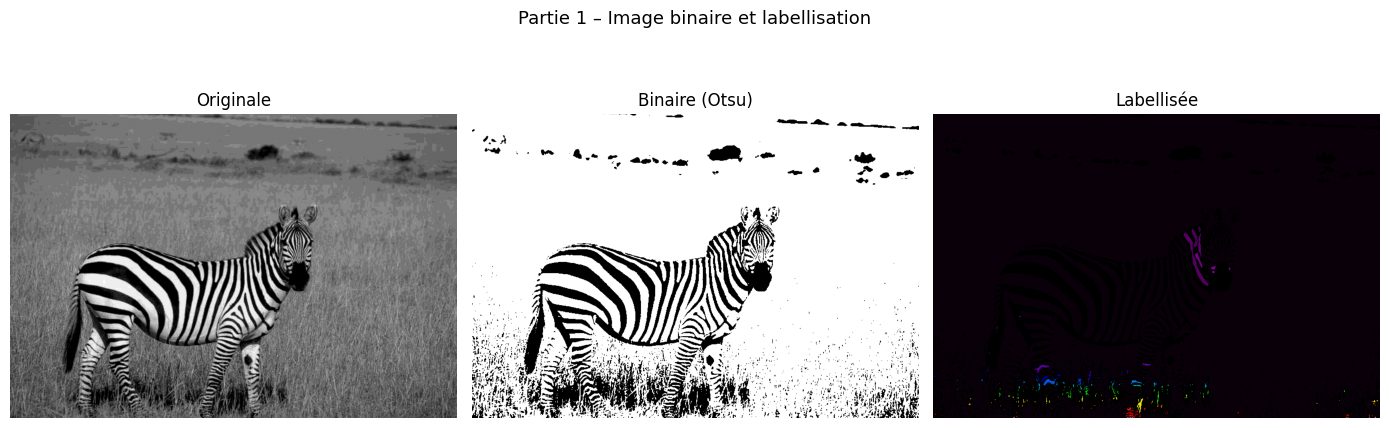

In [ ]:
# Seuillage d'Otsu -> image binaire
seuil_otsu = filters.threshold_otsu(img_gray)
binary_img = img_gray > seuil_otsu

# Labellisation des régions connexes
label_img = measure.label(binary_img)

print(f"Seuil Otsu : {seuil_otsu:.3f}")
print(f"Nombre de régions détectées : {label_img.max()}")

fig, axes = plt.subplots(1, 3, figsize=(14, 5))
fig.suptitle("Partie 1 – Image binaire et labellisation", fontsize=13)

axes[0].imshow(img_gray, cmap='gray')         ; axes[0].set_title("Originale")      ; axes[0].axis('off')
axes[1].imshow(binary_img, cmap='gray')       ; axes[1].set_title("Binaire (Otsu)") ; axes[1].axis('off')
axes[2].imshow(label_img, cmap='nipy_spectral'); axes[2].set_title("Labellisée")    ; axes[2].axis('off')

plt.tight_layout()
plt.show()

## Partie 2 – Moments, aire et centroïde

In [ ]:
# Calcul des propriétés de chaque région
props = measure.regionprops(label_img)

print(f"Propriétés des 8 premières régions (sur {len(props)} au total) :\n")
print(f"{'Région':>7} | {'Aire':>8} | {'Centroïde Y':>12} | {'Centroïde X':>12} | {'Orientation':>12}")
print("-" * 65)

for p in props[:8]:
    cy, cx = p.centroid
    print(f"{p.label:>7} | {p.area:>8} | {cy:>12.1f} | {cx:>12.1f} | {np.degrees(p.orientation):>11.1f}°")

Propriétés des 8 premières régions (sur 251 au total) :

 Région |     Aire |  Centroïde Y |  Centroïde X |  Orientation
-----------------------------------------------------------------
      1 | 444223.0 |        279.4 |        453.6 |        85.8°
      2 |      1.0 |        119.0 |        852.0 |       -45.0°
      3 |      2.0 |        210.0 |        595.5 |        90.0°
      4 |      1.0 |        220.0 |        568.0 |       -45.0°
      5 |      2.0 |        221.0 |        561.5 |        90.0°
      6 |     41.0 |        227.8 |        524.6 |        12.5°
      7 |      1.0 |        225.0 |        582.0 |       -45.0°
      8 |    198.0 |        245.4 |        516.1 |        10.8°


## Partie 3 – Statistiques sur les régions

Statistiques sur les régions :

  Nombre total de régions : 251

  Propriété                 Min      Max    Moyenne    Médiane
  ----------------------------------------------------------
  Aire (px)                 1.0 444223.0     1782.0        3.0
  Périmètre                 0.0  42698.2      177.5        1.0
  Excentricité              0.0      1.0        0.7        0.9


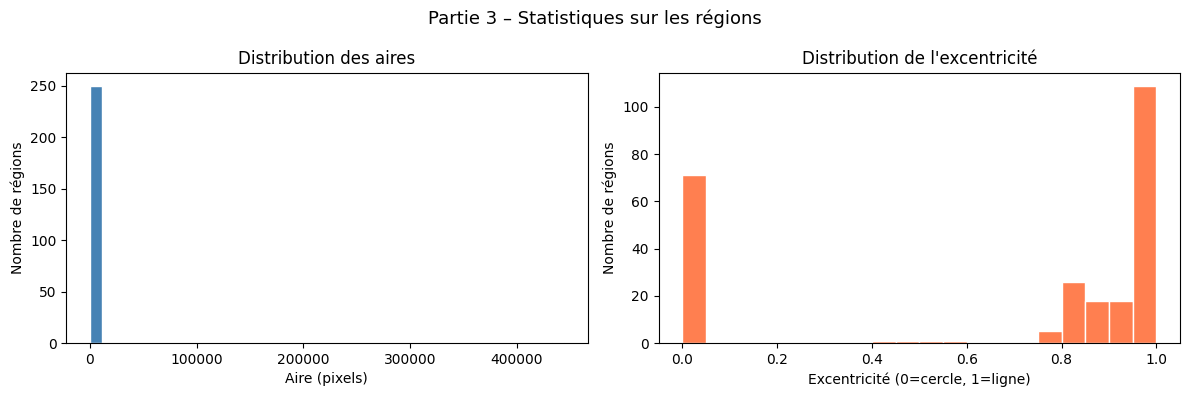

In [ ]:
aires        = np.array([p.area for p in props])
excentricite = np.array([p.eccentricity for p in props])
perimetre    = np.array([p.perimeter for p in props])

print("Statistiques sur les régions :\n")
print(f"  Nombre total de régions : {len(props)}")
print(f"\n  {'Propriété':<20} {'Min':>8} {'Max':>8} {'Moyenne':>10} {'Médiane':>10}")
print("  " + "-" * 58)
for nom, vals in [("Aire (px)", aires), ("Périmètre", perimetre), ("Excentricité", excentricite)]:
    print(f"  {nom:<20} {vals.min():>8.1f} {vals.max():>8.1f} {vals.mean():>10.1f} {np.median(vals):>10.1f}")

# Histogramme des aires
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
fig.suptitle("Partie 3 – Statistiques sur les régions", fontsize=13)

axes[0].hist(aires, bins=40, color='steelblue', edgecolor='white')
axes[0].set_title("Distribution des aires")
axes[0].set_xlabel("Aire (pixels)")
axes[0].set_ylabel("Nombre de régions")

axes[1].hist(excentricite, bins=20, color='coral', edgecolor='white')
axes[1].set_title("Distribution de l'excentricité")
axes[1].set_xlabel("Excentricité (0=cercle, 1=ligne)")
axes[1].set_ylabel("Nombre de régions")

plt.tight_layout()
plt.show()

## Partie 4 – Orientation via les moments centraux

Régions de plus de 200 pixels : 2

 Région |     Aire |  Orient. skimage | Orient. manuelle
-------------------------------------------------------
      1 | 444223.0 |           85.8° |           85.8°
      9 |    679.0 |           19.4° |           19.4°


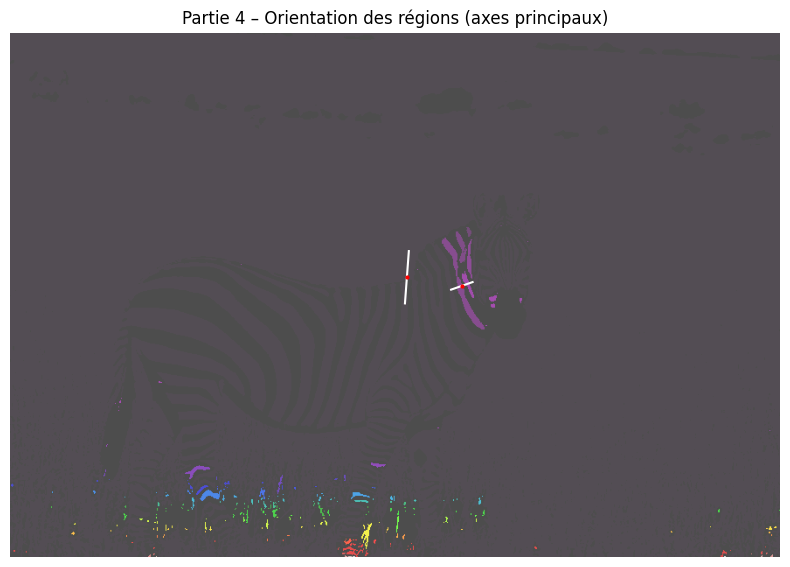

In [ ]:
# Filtrage : on garde uniquement les régions assez grandes
grandes_regions = [p for p in props if p.area > 200]
print(f"Régions de plus de 200 pixels : {len(grandes_regions)}\n")

print(f"{'Région':>7} | {'Aire':>8} | {'Orient. skimage':>16} | {'Orient. manuelle':>16}")
print("-" * 55)

for p in grandes_regions[:10]:
    # Moments centraux disponibles dans regionprops
    mu20 = p.moments_central[2, 0]
    mu02 = p.moments_central[0, 2]
    mu11 = p.moments_central[1, 1]

    # Formule de l'orientation via les moments du second ordre
    theta_manuel = 0.5 * np.arctan2(2 * mu11, mu20 - mu02) if (mu20 - mu02) != 0 else 0.0

    print(f"{p.label:>7} | {p.area:>8} | "
          f"{np.degrees(p.orientation):>14.1f}° | "
          f"{np.degrees(theta_manuel):>14.1f}°")

# Visualisation : dessin des axes d'orientation sur l'image
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(label_img, cmap='nipy_spectral', alpha=0.7)
ax.set_title("Partie 4 – Orientation des régions (axes principaux)")

for p in grandes_regions:
    cy, cx = p.centroid
    angle  = p.orientation
    longueur = min(np.sqrt(p.area) / 2, 30)

    # Axe principal
    dx = longueur * np.cos(angle)
    dy = longueur * np.sin(angle)
    ax.plot([cx - dx, cx + dx], [cy + dy, cy - dy], 'w-', lw=1.5)
    ax.plot(cx, cy, 'r.', markersize=4)

ax.axis('off')
plt.tight_layout()
plt.show()